<a href="https://colab.research.google.com/github/glebmikha/ds-course/blob/main/07_classification_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Мой Telegram-канал: https://t.me/mikhaylovgleb

# Загрузка данных

https://www.kaggle.com/shubh0799/churn-modelling

https://drive.google.com/file/d/1Ym8EaWePP17RvrweKhWzCJmITXLgqvCZ/view?usp=sharing

In [ ]:
! gdown --id 1Ym8EaWePP17RvrweKhWzCJmITXLgqvCZ

Downloading...
From: https://drive.google.com/uc?id=1Ym8EaWePP17RvrweKhWzCJmITXLgqvCZ
To: /content/churn-modeling.zip
100% 268k/268k [00:00<00:00, 36.7MB/s]


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/churn-modeling.zip')

# Обучающая, валидационная и тестовая выборка

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(df,train_size=0.6,random_state=42,stratify=df['Exited'])

In [ ]:
val, test = train_test_split(test,train_size=0.5,random_state=42,stratify=test['Exited'])

# Человеческое обучение

In [ ]:
train['age_group'] = pd.cut(train['Age'],[0,31,35,40,46,float('inf')])

In [ ]:
model = train.groupby(['NumOfProducts','age_group'])['Exited'].mean().reset_index()

In [ ]:
model = model.rename({'Exited':'score_prod_age'},axis=1)

In [ ]:
train = train.merge(model,how='left',on=['NumOfProducts','age_group'])

In [ ]:
test['age_group'] = pd.cut(test['Age'],[0,31,35,40,46,float('inf')])

In [ ]:
test = test.merge(model,how='left',on=['NumOfProducts','age_group'])

# Машинное обучение

In [ ]:
! pip install catboost

     |████████████████████████████████| 76.1 MB 50 kB/s 


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
X = ['CustomerId', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']

cat_features = ['Geography','Gender']

y = ['Exited']

In [ ]:
from catboost import Pool

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )

In [ ]:
params = {'verbose':100,
          'random_seed':42,
          'learning_rate':0.01}

In [ ]:
model = CatBoostClassifier(**params)

In [ ]:
model.fit(train_data,eval_set=valid_data)

0:	learn: 0.6848575	test: 0.6849145	best: 0.6849145 (0)	total: 77.4ms	remaining: 1m 17s
100:	learn: 0.3908412	test: 0.3894043	best: 0.3894043 (100)	total: 1.58s	remaining: 14.1s
200:	learn: 0.3457312	test: 0.3445503	best: 0.3445503 (200)	total: 2.32s	remaining: 9.22s
300:	learn: 0.3288071	test: 0.3307084	best: 0.3307084 (300)	total: 3.05s	remaining: 7.09s
400:	learn: 0.3192987	test: 0.3252459	best: 0.3252459 (400)	total: 3.98s	remaining: 5.94s
500:	learn: 0.3120470	test: 0.3221057	best: 0.3221057 (500)	total: 4.7s	remaining: 4.68s
600:	learn: 0.3054735	test: 0.3204300	best: 0.3204300 (600)	total: 5.44s	remaining: 3.61s
700:	learn: 0.2997053	test: 0.3192377	best: 0.3192377 (700)	total: 6.17s	remaining: 2.63s
800:	learn: 0.2946934	test: 0.3188206	best: 0.3187917 (794)	total: 7.19s	remaining: 1.78s
900:	learn: 0.2890177	test: 0.3185731	best: 0.3185731 (900)	total: 9.1s	remaining: 1s
999:	learn: 0.2831978	test: 0.3186396	best: 0.3185004 (978)	total: 10.8s	remaining: 0us

bestTest = 0.31850

In [ ]:
test['score_catboost'] = model.predict_proba(test[X])[:,1]

# Скор и пороги

In [ ]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0.0, 31.0]",0.110764,0.131844
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31.0, 35.0]",0.140449,0.074020
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35.0, 40.0]",0.209337,0.186876
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,1,0,121982.73,0,"(31.0, 35.0]",0.140449,0.087403
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,1,1,115767.93,0,"(31.0, 35.0]",0.140449,0.056658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,1,1,138350.74,0,"(46.0, inf]",0.236364,0.026803
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,1,1,24802.77,0,"(35.0, 40.0]",0.209337,0.084712
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,1,0,34888.04,1,"(40.0, 46.0]",0.108647,0.149411
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,1,1,138470.21,0,"(35.0, 40.0]",0.061069,0.063715


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

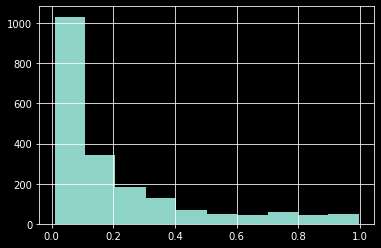

In [ ]:
test['score_catboost'].hist()

In [ ]:
train['Exited'].mean()

0.20366666666666666

In [ ]:
True * 1

1

In [ ]:
False * 1

0

In [ ]:
test['y_pred'] = (test['score_catboost'] > 0.5) * 1

In [ ]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0.0, 31.0]",0.110764,0.131844,0
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31.0, 35.0]",0.140449,0.074020,0
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35.0, 40.0]",0.209337,0.186876,0
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,1,0,121982.73,0,"(31.0, 35.0]",0.140449,0.087403,0
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,1,1,115767.93,0,"(31.0, 35.0]",0.140449,0.056658,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,1,1,138350.74,0,"(46.0, inf]",0.236364,0.026803,0
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,1,1,24802.77,0,"(35.0, 40.0]",0.209337,0.084712,0
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,1,0,34888.04,1,"(40.0, 46.0]",0.108647,0.149411,0
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,1,1,138470.21,0,"(35.0, 40.0]",0.061069,0.063715,0


In [ ]:
test['y_pred'].mean()

0.1225

# Матрица ошибок

In [ ]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0.0, 31.0]",0.110764,0.131844,0
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31.0, 35.0]",0.140449,0.074020,0
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35.0, 40.0]",0.209337,0.186876,0
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,1,0,121982.73,0,"(31.0, 35.0]",0.140449,0.087403,0
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,1,1,115767.93,0,"(31.0, 35.0]",0.140449,0.056658,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,1,1,138350.74,0,"(46.0, inf]",0.236364,0.026803,0
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,1,1,24802.77,0,"(35.0, 40.0]",0.209337,0.084712,0
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,1,0,34888.04,1,"(40.0, 46.0]",0.108647,0.149411,0
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,1,1,138470.21,0,"(35.0, 40.0]",0.061069,0.063715,0


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(test['Exited'],test['y_pred'])

array([[1537,   56],
       [ 218,  189]])

In [ ]:
confusion_matrix(test['Exited'],test['y_pred'])

array([[1537,   56],
       [ 218,  189]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(test['Exited'],test['y_pred']).ravel()

In [ ]:
tn, fp, fn, tp

(1537, 56, 218, 189)

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

# Recall (полнота)

In [ ]:
recall = tp / (tp + fn)

In [ ]:
recall

0.4643734643734644

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
recall_score(test['Exited'],test['y_pred'])

0.4643734643734644

In [ ]:
test['y_pred_1'] = 1

In [ ]:
recall_score(test['Exited'],test['y_pred_1'])

1.0

# Precision (точность)

In [ ]:
precision = tp / (tp + fp)

In [ ]:
precision

0.7714285714285715

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
precision_score(test['Exited'],test['y_pred'])

0.7714285714285715

In [ ]:
precision_score(test['Exited'],test['y_pred_1'])

0.2035

In [ ]:
test['Exited'].mean()

0.2035

# F1

In [ ]:
f1 = (2 * recall * precision) / (recall + precision)

In [ ]:
f1

0.5797546012269938

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(test['Exited'],test['y_pred'])

0.5797546012269938

# Accuracy

In [ ]:
(test['Exited'] == test['y_pred']).mean()

0.863

In [ ]:
(tp + tn) / (tp + tn + fp + fn)

0.863

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(test['Exited'],test['y_pred'])

0.863

In [ ]:
test['Exited'].mean()

0.2035

In [ ]:
test['y_pred_0'] = 0

In [ ]:
accuracy_score(test['Exited'],test['y_pred_0'])

0.7965

In [ ]:
1 - test['Exited'].mean()

0.7965

# Classification report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test['Exited'],test['y_pred']))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.77      0.46      0.58       407

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000



In [ ]:
precision

0.7714285714285715

In [ ]:
recall

0.4643734643734644

In [ ]:
f1

0.5797546012269938

# Предикт с другим порогом

In [ ]:
test['y_pred_new'] = (test['score_catboost'] > 0.4) * 1

In [ ]:
f1_score(test['Exited'],test['y_pred'])

0.5797546012269938

In [ ]:
f1_score(test['Exited'],test['y_pred_new'])

0.6104972375690608

In [ ]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred,y_pred_1,y_pred_0,y_pred_new
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,...,0,29818.20,0,"(0.0, 31.0]",0.110764,0.131844,0,1,0,0
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,...,0,187740.04,0,"(31.0, 35.0]",0.140449,0.074020,0,1,0,0
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,...,0,19658.43,0,"(35.0, 40.0]",0.209337,0.186876,0,1,0,0
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,...,0,121982.73,0,"(31.0, 35.0]",0.140449,0.087403,0,1,0,0
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,...,1,115767.93,0,"(31.0, 35.0]",0.140449,0.056658,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,...,1,138350.74,0,"(46.0, inf]",0.236364,0.026803,0,1,0,0
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,...,1,24802.77,0,"(35.0, 40.0]",0.209337,0.084712,0,1,0,0
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,...,0,34888.04,1,"(40.0, 46.0]",0.108647,0.149411,0,1,0,0
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,...,1,138470.21,0,"(35.0, 40.0]",0.061069,0.063715,0,1,0,0


In [ ]:
len(test['score_catboost'])

2000

In [ ]:
test['score_catboost'].nunique()

2000

In [ ]:
thrs = [0] + list(test['score_catboost'].unique())

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
result = []
for thr in tqdm(thrs):
  test['y_pred_new'] = (test['score_catboost'] > thr) * 1
  result.append((thr,
                 f1_score(test['Exited'],test['y_pred_new'])))

  0%|          | 0/2001 [00:00<?, ?it/s]

In [ ]:
result[:10]

[(0, 0.3381803074366431),
 (0.13184386080460458, 0.5536277602523659),
 (0.07401954387476314, 0.47174447174447176),
 (0.18687567474270395, 0.5938069216757741),
 (0.0874034938715728, 0.4940239043824701),
 (0.056658162909274605, 0.43680709534368073),
 (0.06161072773132977, 0.44610091743119257),
 (0.5563161171624521, 0.5544871794871795),
 (0.20388734500811342, 0.6096153846153847),
 (0.0455555402676573, 0.40841457157516675)]

In [ ]:
t = pd.DataFrame(result,columns=['thr','f1'])

In [ ]:
t.sort_values('f1',ascending=False)

,thr,f1
640,0.277932,0.636771
623,0.280837,0.636569
1343,0.276637,0.636058
1756,0.331582,0.636025
1228,0.278005,0.635955
...,...,...
238,0.992916,0.019465
315,0.993195,0.014634
180,0.994941,0.009780
1205,0.997245,0.004902


In [ ]:
t[t['f1'] == t['f1'].max()]

,thr,f1
640,0.277932,0.636771


In [ ]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred,y_pred_1,y_pred_0,y_pred_new
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,...,0,29818.20,0,"(0.0, 31.0]",0.110764,0.131844,0,1,0,1
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,...,0,187740.04,0,"(31.0, 35.0]",0.140449,0.074020,0,1,0,1
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,...,0,19658.43,0,"(35.0, 40.0]",0.209337,0.186876,0,1,0,1
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,...,0,121982.73,0,"(31.0, 35.0]",0.140449,0.087403,0,1,0,1
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,...,1,115767.93,0,"(31.0, 35.0]",0.140449,0.056658,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,...,1,138350.74,0,"(46.0, inf]",0.236364,0.026803,0,1,0,0
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,...,1,24802.77,0,"(35.0, 40.0]",0.209337,0.084712,0,1,0,1
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,...,0,34888.04,1,"(40.0, 46.0]",0.108647,0.149411,0,1,0,1
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,...,1,138470.21,0,"(35.0, 40.0]",0.061069,0.063715,0,1,0,1


In [ ]:
thrs = [0] + list(test['score_prod_age'].unique())

In [ ]:
len(thrs)

17

In [ ]:
result = []
for thr in tqdm(thrs):
  test['y_pred_new'] = (test['score_prod_age'] > thr) * 1
  result.append((thr,
                 f1_score(test['Exited'],test['y_pred_new'])))

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
result[:10]

[(0, 0.3381803074366431),
 (0.11076443057722309, 0.4838940586972082),
 (0.1404494382022472, 0.5156507413509062),
 (0.20933734939759036, 0.5372233400402414),
 (0.5276073619631901, 0.21888412017167383),
 (0.10864745011086474, 0.45387453874538747),
 (0.028037383177570093, 0.3596608656849621),
 (0.061068702290076333, 0.43132803632236094),
 (0.23636363636363636, 0.5594405594405594),
 (0.033288948069241014, 0.3991995997999)]

In [ ]:
t = pd.DataFrame(result,columns=['thr','f1'])

In [ ]:
t[t['f1'] == t['f1'].max()]

,thr,f1
8,0.236364,0.559441


# ROC

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fprs, tprs, thrs = roc_curve(test['Exited'],test['score_catboost'])

In [ ]:
roc = pd.DataFrame({'fpr':fprs,'tpr':tprs,'thr':thrs})

In [ ]:
roc

,fpr,tpr,thr
0,0.000000,0.000000,1.997318
1,0.000000,0.002457,0.997318
2,0.000000,0.061425,0.933737
3,0.000628,0.061425,0.933203
4,0.000628,0.120393,0.891551
...,...,...,...
391,0.979912,0.995086,0.012212
392,0.979912,0.997543,0.012198
393,0.998745,0.997543,0.009886
394,0.998745,1.000000,0.009809


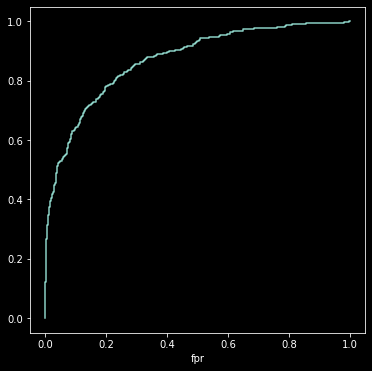

In [ ]:
roc.set_index('fpr')['tpr'].plot(figsize=(6,6))

In [ ]:
roc['random'] = roc['fpr']

In [ ]:
roc['ideal'] = 1

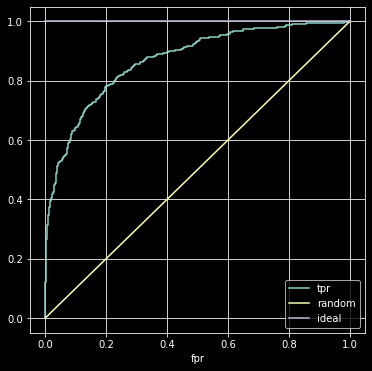

In [ ]:
roc.plot(x='fpr',y=['tpr','random','ideal'],figsize=(6,6),grid=True)

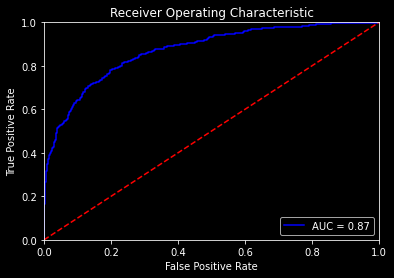

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(test['Exited'], test['score_catboost'])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from catboost.utils import get_roc_curve

In [ ]:
test_data = Pool(data=test[X],
                  label=test[y],
                  cat_features=cat_features
                 )

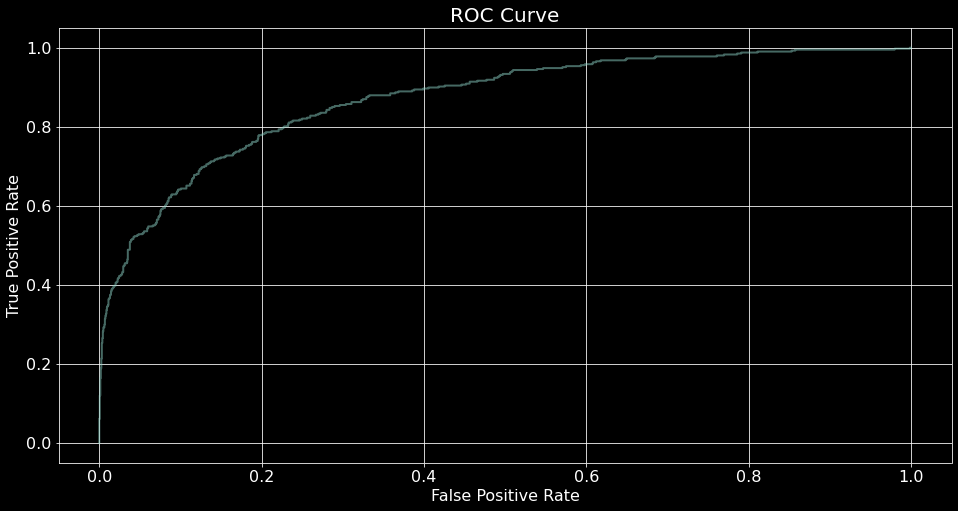

In [ ]:
get_roc_curve(model,test_data,plot=True);

# AUC

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(test['Exited'],test['score_catboost'])

0.8703063618317854

In [ ]:
params = {'verbose':100,
          'eval_metric':'AUC',
          'random_seed':42,
          'learning_rate':0.01}

In [ ]:
model = CatBoostClassifier(**params)

In [ ]:
model.fit(train_data,eval_set=valid_data)

0:	test: 0.8338545	best: 0.8338545 (0)	total: 14.5ms	remaining: 14.5s
100:	test: 0.8725090	best: 0.8725090 (100)	total: 2.02s	remaining: 18s
200:	test: 0.8784656	best: 0.8784656 (200)	total: 3.9s	remaining: 15.5s
300:	test: 0.8812676	best: 0.8812676 (300)	total: 5.71s	remaining: 13.3s
400:	test: 0.8823868	best: 0.8824376 (390)	total: 7.82s	remaining: 11.7s
500:	test: 0.8834491	best: 0.8834522 (498)	total: 10.1s	remaining: 10s
600:	test: 0.8834737	best: 0.8836554 (564)	total: 12s	remaining: 7.99s
700:	test: 0.8837847	best: 0.8838694 (685)	total: 14.2s	remaining: 6.06s
800:	test: 0.8834383	best: 0.8838694 (685)	total: 16s	remaining: 3.96s
900:	test: 0.8829318	best: 0.8838694 (685)	total: 18.2s	remaining: 2s
999:	test: 0.8822744	best: 0.8838694 (685)	total: 20.2s	remaining: 0us

bestTest = 0.8838694083
bestIteration = 685

Shrink model to first 686 iterations.


# ROC AUC при сильно несбалансированных классах

In [ ]:
t = pd.DataFrame({'y_true':[0]*990 + [1]*10})

In [ ]:
t['y_true'].mean()

0.01

In [ ]:
import numpy as np

In [ ]:
np.random.uniform(0,0.2)

0.08337599061471385

In [ ]:
np.random.uniform(0.8,1)

0.803459731165204

In [ ]:
np.concatenate([np.random.uniform(0,0.2,size=2),np.random.uniform(0.8,1,size=3)])

array([0.05676313, 0.121761  , 0.99962411, 0.91822572, 0.83530108])

In [ ]:
t = pd.DataFrame({'y_true':[0]*990 + [1]*10})

In [ ]:
np.random.seed(42)
t['y_score1'] = np.concatenate([np.random.uniform(0,0.2,size=970), # TN
                                np.random.uniform(0.8,1,size=20), # FP
                                np.random.uniform(0,0.2,size=5), # FN
                                np.random.uniform(0.8,1,size=5)]) # TP

In [ ]:
roc_auc_score(t['y_true'],t['y_score1'])

0.7664646464646465

In [ ]:
np.random.seed(42)
t['y_score2'] = np.concatenate([np.random.uniform(0,0.2,size=850), # TN
                                np.random.uniform(0.8,1,size=140), # FP
                                np.random.uniform(0,0.2,size=2), # FN
                                np.random.uniform(0.8,1,size=8)]) # TP

In [ ]:
roc_auc_score(t['y_true'],t['y_score2'])

0.873939393939394

# Precision recall curve

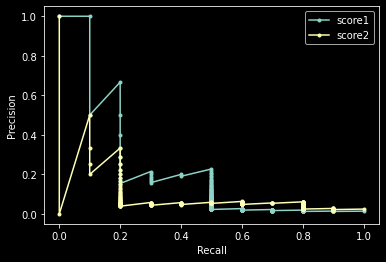

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

precision1, recall1, _ = precision_recall_curve(t['y_true'], t['y_score1'])
precision2, recall2, _ = precision_recall_curve(t['y_true'], t['y_score2'])


# plot the precision-recall curves
pyplot.plot(recall1, precision1, marker='.', label='score1')
pyplot.plot(recall2, precision2, marker='.', label='score2')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
from sklearn.metrics import average_precision_score

In [ ]:
average_precision_score(t['y_true'],t['y_score1'])

0.24047423356816472

In [ ]:
average_precision_score(t['y_true'],t['y_score2'])

0.12387717860283662

# Сравним человеческое и машинное обучение



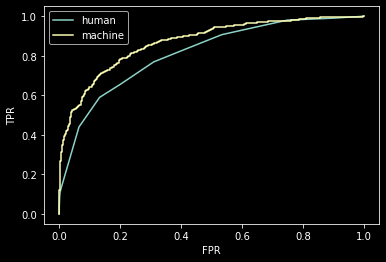

In [ ]:
fpr1, tpr1, _ = roc_curve(test['Exited'], test['score_prod_age'])
fpr2, tpr2, _ = roc_curve(test['Exited'], test['score_catboost'])


# plot the precision-recall curves
pyplot.plot(fpr1, tpr1, label='human')
pyplot.plot(fpr2, tpr2, label='machine')
# axis labels
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
roc_auc_score(test['Exited'], test['score_prod_age'])

0.8115241589817861

In [ ]:
roc_auc_score(test['Exited'], test['score_catboost'])

0.8703063618317854

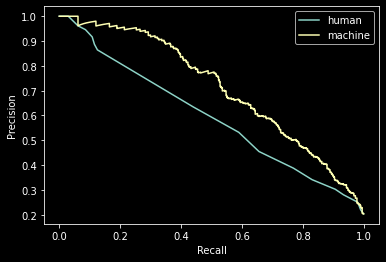

In [ ]:
precision1, recall1, _ = precision_recall_curve(test['Exited'], test['score_prod_age'])
precision2, recall2, _ = precision_recall_curve(test['Exited'], test['score_catboost'])


# plot the precision-recall curves
pyplot.plot(recall1, precision1, label='human')
pyplot.plot(recall2, precision2, label='machine')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
average_precision_score(test['Exited'], test['score_prod_age'])

0.539602947873155

In [ ]:
average_precision_score(test['Exited'], test['score_catboost'])

0.7138074084585948

# Дисбаланс классов не проблема

In [ ]:
test['Exited'].mean()

0.2035

In [ ]:
params = {'verbose':100,
          'eval_metric':'AUC',
          'auto_class_weights':'Balanced',
          'random_seed':42,
          'learning_rate':0.01}

In [ ]:
model = CatBoostClassifier(**params)

In [ ]:
model.fit(train_data,eval_set=valid_data)

0:	test: 0.8310171	best: 0.8310171 (0)	total: 22.8ms	remaining: 22.8s
100:	test: 0.8726691	best: 0.8727215 (99)	total: 1.57s	remaining: 14s
200:	test: 0.8780837	best: 0.8781684 (199)	total: 3.25s	remaining: 12.9s
300:	test: 0.8805532	best: 0.8806579 (293)	total: 4.87s	remaining: 11.3s
400:	test: 0.8818510	best: 0.8818649 (397)	total: 6.46s	remaining: 9.66s
500:	test: 0.8821682	best: 0.8822452 (481)	total: 7.63s	remaining: 7.6s
600:	test: 0.8824284	best: 0.8826070 (561)	total: 8.4s	remaining: 5.57s
700:	test: 0.8823145	best: 0.8826070 (561)	total: 9.18s	remaining: 3.91s
800:	test: 0.8819619	best: 0.8826070 (561)	total: 9.95s	remaining: 2.47s
900:	test: 0.8814015	best: 0.8826070 (561)	total: 10.7s	remaining: 1.18s
999:	test: 0.8803392	best: 0.8826070 (561)	total: 11.5s	remaining: 0us

bestTest = 0.8826069687
bestIteration = 561

Shrink model to first 562 iterations.


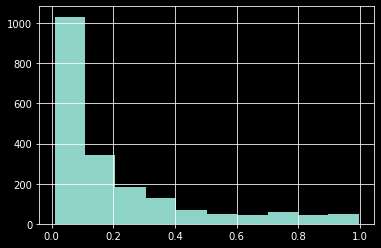

In [ ]:
test['score_catboost'].hist()

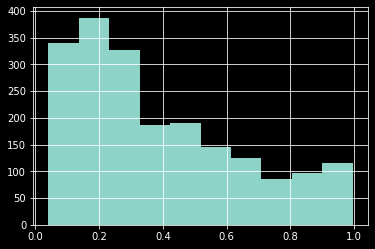

In [ ]:
pd.Series(model.predict_proba(test[X])[:,1]).hist()

In [ ]:
test['score_cat_non_balanced_bins'] = pd.cut(test['score_catboost'],10)

In [ ]:
test.groupby('score_cat_non_balanced_bins')['Exited'].agg(['count','mean'])

,count,mean
score_cat_non_balanced_bins,,
"(0.00838, 0.108]",1032,0.043605
"(0.108, 0.207]",343,0.142857
"(0.207, 0.306]",184,0.260870
"(0.306, 0.405]",128,0.359375
"(0.405, 0.503]",69,0.434783
"(0.503, 0.602]",49,0.530612
"(0.602, 0.701]",42,0.595238
"(0.701, 0.8]",59,0.830508
"(0.8, 0.899]",45,0.911111


In [ ]:
test['score_catboost_balanced'] = model.predict_proba(test[X])[:,1]

In [ ]:
test['score_cat_balanced_bins'] = pd.cut(test['score_catboost_balanced'],10)

In [ ]:
test.groupby('score_cat_balanced_bins')['Exited'].agg(['count','mean'])

,count,mean
score_cat_balanced_bins,,
"(0.0404, 0.137]",340,0.011765
"(0.137, 0.232]",387,0.036176
"(0.232, 0.328]",327,0.082569
"(0.328, 0.423]",187,0.139037
"(0.423, 0.518]",190,0.210526
"(0.518, 0.614]",146,0.191781
"(0.614, 0.709]",125,0.464000
"(0.709, 0.805]",85,0.447059
"(0.805, 0.9]",97,0.670103


In [ ]:
(4 + 13) / 2

8.5

# Мультикласс


https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd

https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

Мой Telegram-канал: https://t.me/mikhaylovgleb